In [170]:
# Study Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,  make_scorer, recall_score, roc_auc_score, average_precision_score

# Data preparation Libs
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna
from sklearn.pipeline import Pipeline

# ML Libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Discovery

In [171]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [172]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [174]:
df.duplicated().sum()

np.int64(1081)

We'll drop the duplicate, same amount, same caracteristics, same time... yeah...

In [175]:
df.drop_duplicates(inplace=True)

In [176]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [177]:
print('Frauds', round(len(df[df['Class'] == 1])/len(df) * 100,2), '% of the dataset')
print('No Frauds', round(len(df[df['Class'] == 0])/len(df) * 100,2), '% of the dataset')

Frauds 0.17 % of the dataset
No Frauds 99.83 % of the dataset


**Information:** Wow We have a huge disproportion here, we'll have to consider it during our ML phase.

## Exploration

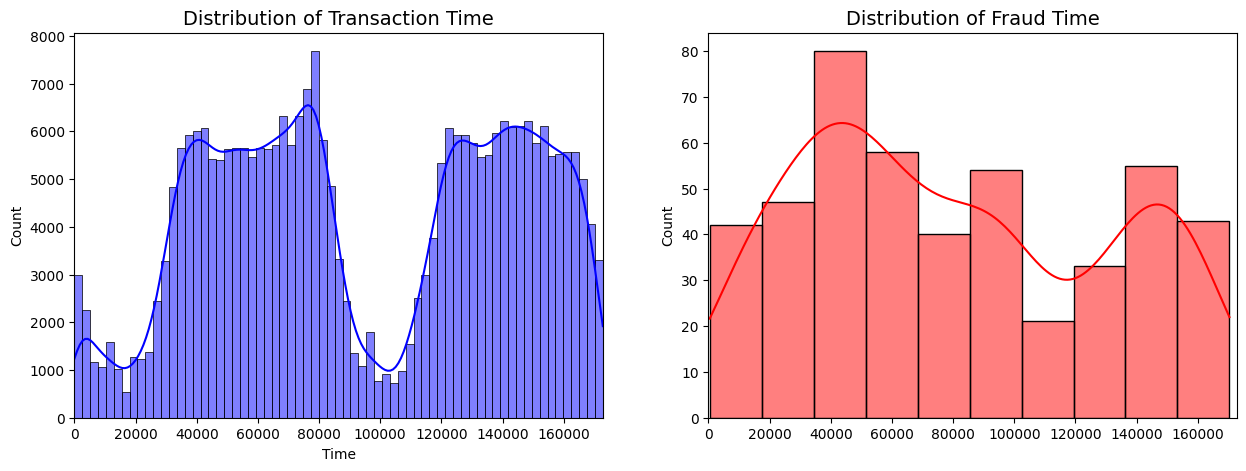

In [178]:
# Let's study the time!
# Time distribution:

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(df['Time'], color='b', kde=True)
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

# Fraud distribution over time
plt.subplot(1,2,2)
sns.histplot(df[df['Class']==1]['Time'].values, color='r', kde=True)
plt.title('Distribution of Fraud Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

plt.show()

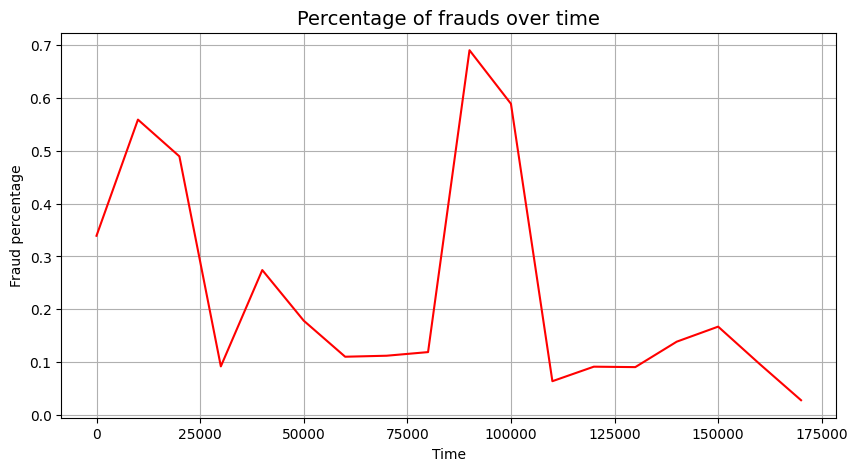

In [179]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraude_ratio = df.groupby('Time_bin')['Class'].agg(['count', 'sum'])
fraude_ratio['fraude_ratio'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraude_ratio.index, y=fraude_ratio['fraude_ratio'], color='red')
plt.title('Percentage of frauds over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Fraud percentage')
plt.grid(True)
plt.show()

**Information:** Okay! So the proportion seems to be more important at times where there is fewer transactions. It was kind of predictable by looking at the thin difference of fraud count in the previous graph but heh, now we know!

Amount infos
count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64
Amount infos on Fraud transactions
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


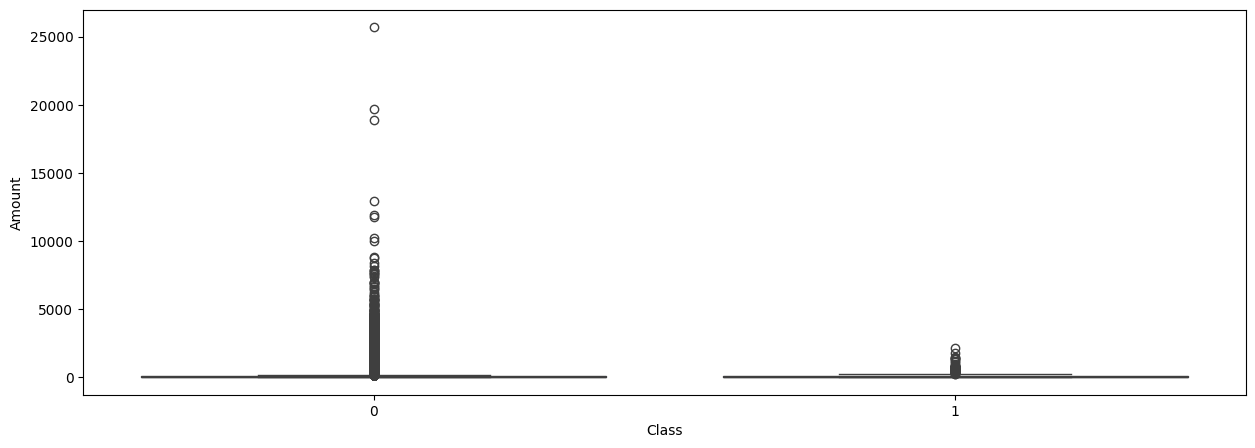

In [180]:
# Let's talk about amounts now!
print('Amount infos')
print(df['Amount'].describe())
print('Amount infos on Fraud transactions')
print(df[df['Class']==1]['Amount'].describe())

plt.figure(figsize=(15,5))
sns.boxplot(data = df, x='Class', y='Amount')
# plt.ylim(-100, max(df[df['Class']==1]['Amount'])+200)
plt.show()

**Information:** Ok on global the mean and median of transactions are quite low. The STD is quite similar between Fraud and not Fraud. The mean and median is higher in the Fraud section however. A bit informative but not too much here...

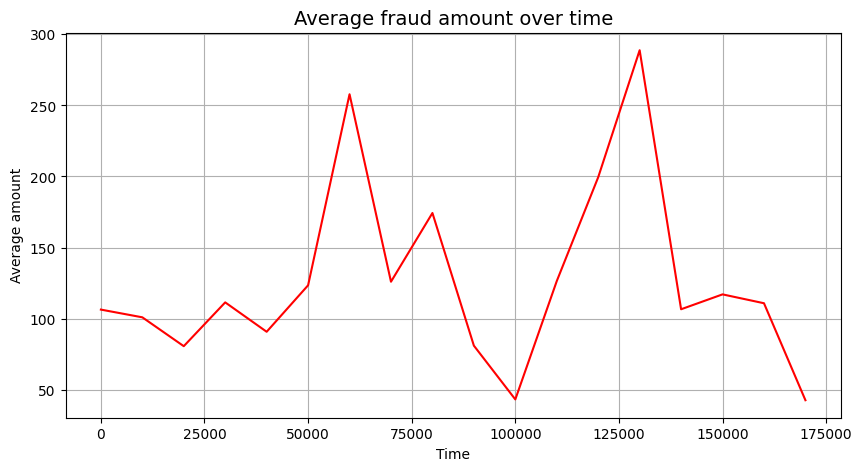

In [181]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraud_amount = df[df['Class'] ==1].groupby('Time_bin')['Amount'].agg(['mean'])
# fraude_amount['fraude_amount'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraud_amount.index, y=fraud_amount['mean'], color='red')
plt.title('Average fraud amount over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Average amount')
plt.grid(True)
plt.show()

## Features exploration

**Let's talk about features!**

Now we'll talk about feature importance. We'll try to understand which feature has an influence on the target.
To do that we'll have to change the propotion to avoid the noise of the vast majority of non fraud.
We'll have to SPLIT!
Why? We want something robust, precise, so we'll make our study on a train set, 
leaving our test set out to have a maximum of reality coming into our model during the final prediction.

*BUT*

We have to do it properly. We have time stamps so if we shuffle and stratify we'll creat time bias by giving our model information from the future for predicting transactions in the past. We don't want that.
We'll split manually, choosing the "Time" section to only the 80% past and 20% future as train/test.
We'll have to check the proportion however, if we don't have enough frauds in the test set won't be able to measure the effectiveness of our model.
The val set will be useful later, as comparisons with others methods.

In [182]:
df_sorted = df.sort_values(by="Time", ascending = True)
split_index_test = int(len(df_sorted)*0.70)
split_index_val = int(len(df_sorted)*0.85)
train_df = df_sorted[:split_index_test]
test_df = df_sorted[split_index_test:split_index_val]
val_df = df_sorted[split_index_val:]
print(f"{len(train_df)} pour le train, {len(test_df)} pour le test et {len(val_df)} pour le val")

198608 pour le train, 42559 pour le test et 42559 pour le val


In [183]:
X_original_train = train_df.drop(columns=['Class', 'Time_bin'])
y_original_train = train_df['Class']
print('In train set we have:')
print('Frauds', round(len(y_original_train[y_original_train == 1])/len(y_original_train) * 100,2), '% of the dataset')
print('No Frauds', round(len(y_original_train[y_original_train == 0])/len(y_original_train) * 100,2), '% of the dataset')


X_original_test = test_df.drop(columns=['Class', 'Time_bin'])
y_original_test = test_df['Class']
print('In test set we have:')
print('Frauds', round(len(y_original_test[y_original_test == 1])/len(y_original_test) * 100,2), '% of the dataset')
print('No Frauds', round(len(y_original_test[y_original_test == 0])/len(y_original_test) * 100,2), '% of the dataset')

X_original_val = val_df.drop(columns=['Class', 'Time_bin'])
y_original_val = val_df['Class']
print('In val set we have:')
print('Frauds', round(len(y_original_val[y_original_val == 1])/len(y_original_val) * 100,2), '% of the dataset')
print('No Frauds', round(len(y_original_val[y_original_val == 0])/len(y_original_val) * 100,2), '% of the dataset')

In train set we have:
Frauds 0.18 % of the dataset
No Frauds 99.82 % of the dataset
In test set we have:
Frauds 0.13 % of the dataset
No Frauds 99.87 % of the dataset
In val set we have:
Frauds 0.12 % of the dataset
No Frauds 99.88 % of the dataset


Ok the proportions are decent enough to work with!

In [184]:
# Let's scale the time and amout! We use Robust scaler, he is more robust with the presence of outliers

scaler= RobustScaler()

X_rescaled = scaler.fit_transform(X_original_train[['Amount', 'Time']])
X_rescaled = pd.DataFrame(X_rescaled, columns=['scaled_amount', 'scaled_time'], index=X_original_train.index)
X_original_train = pd.concat([X_original_train, X_rescaled], axis=1)
X_original_train.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_train.tail(3))

# Ok now for the test part! We only transform her, no data leak!

X_rescaled_t = scaler.transform(X_original_test[['Amount', 'Time']])
X_rescaled_t = pd.DataFrame(X_rescaled_t, columns=['scaled_amount', 'scaled_time'], index=X_original_test.index)
X_original_test = pd.concat([X_original_test, X_rescaled_t], axis=1)
X_original_test.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_test.tail(3))

# And finally the val

X_rescaled_v = scaler.transform(X_original_val[['Amount', 'Time']])
X_rescaled_v = pd.DataFrame(X_rescaled_v, columns=['scaled_amount', 'scaled_time'], index=X_original_val.index)
X_original_val = pd.concat([X_original_val, X_rescaled_v], axis=1)
X_original_val.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_val.tail(3))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
199322,-0.473957,1.460497,-0.687928,-0.454381,0.375335,-1.071949,0.634231,0.306173,-0.096931,-0.769087,...,-0.291834,-0.740368,0.228400,0.986072,-0.409673,0.095856,0.211713,0.084178,-0.190483,1.392447
199320,1.774140,-1.081432,-0.092484,0.194936,-0.816991,0.975553,-1.165119,0.434134,1.988660,-0.287526,...,0.011771,0.198132,0.160598,0.246077,-0.361527,-0.057863,0.030006,-0.027821,0.870156,1.392447
199323,-2.029921,1.931641,-0.846619,-2.566857,-0.188931,-1.259749,0.143424,1.171376,0.011258,-1.272876,...,-0.231327,-0.932421,0.079977,0.648337,0.103004,0.359834,0.054482,0.102015,-0.299116,1.392469


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
242061,-0.275940,1.283705,-0.548781,-0.471862,0.836178,-0.565283,0.861091,0.000310,-0.058153,-0.074906,...,-0.193372,-0.395935,0.237368,0.653847,-1.350706,0.024148,0.428683,0.399399,-0.276139,1.782881
242066,-2.151693,1.830070,0.383185,-0.727324,0.445011,-0.134313,0.996493,-0.098386,0.753571,1.078361,...,-0.337734,-0.585060,-0.426802,-0.608266,0.829456,-0.665027,-0.547778,-0.118942,-0.095173,1.782902
242065,0.193179,0.616617,-2.364968,-1.240914,2.693081,3.325777,-0.243321,1.332511,0.070426,-1.181968,...,0.139113,0.415622,0.056712,0.661800,-0.568238,0.494024,-0.076585,-0.042101,-0.244731,1.782902


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.610197,2.238089
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.176751,2.238089
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,2.637661,2.238174


Now that we have split, we can play on the train, we will start by evaluating the feature importance.
We will start with the ROC AUC. The advantage of the ROC AUC is that our class imbalance is not a problem with this metric.

*What is it?*
The Univariate AUC analysis measures the capacity of target class separation of a feature.
The analysis tests multiples thresholds (a threshold is a value of our feature in general) on the feature and ask the question: 
"Will my target will be 1 if the feature is above this thershold?"
Like a simple classifier, it then give us True Positive Rates (TPR) and False Positive Rates (FPR) and then it plots the TPR against the FPR.

*How do we read it?*
We have a curve and we take the Area Under the Curve. If this area is close to 1, the feature is a great separator.
If the area is 0.5, it's pure random.
If the area is lower than 0.5, the more it goes to 0 the more we should do the opposite of the feature to make a good separation.

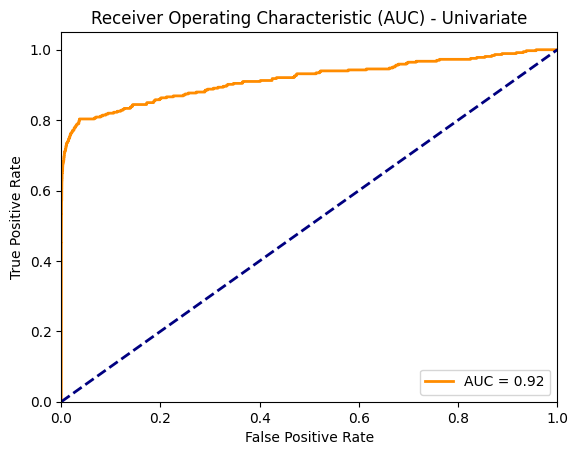

In [185]:
# Exemple avec la feature 'V14' et les labels 'y'
fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train['V11'])
roc_auc = auc(fpr, tpr)

# Tracer la ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC) - Univariate')
plt.legend(loc='lower right')
plt.show()

In [186]:
df_roc_auc = pd.DataFrame()
i=0
for col in X_original_train.columns:
    fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train[col])
    roc_auc = auc(fpr, tpr)
    df_roc_auc.loc[i, 'Cols'] = col
    df_roc_auc.loc[i, 'ROC_AUC'] = roc_auc
    i+= 1
display(df_roc_auc.sort_values('ROC_AUC', ascending= False))

,Cols,ROC_AUC
3,V4,0.937321
10,V11,0.915229
1,V2,0.873526
20,V21,0.744319
26,V27,0.696513
18,V19,0.675616
7,V8,0.666901
19,V20,0.645508
27,V28,0.632161
21,V22,0.527779


Now we'll try something else. The Pearson correlation. The problem with that is that we have a heavily imbalanced dataset.
To avoid noise we'll have to balance this.

*How?*
Undersampling. We'll create a smaller df with all the frauds and the same number of non-fraud. It will help us to have a clearer view of the correlation
BUT!
Doing that we'll have a huge bias, the random sample of non fraud used may be extremely specific and give us misleading correlations.

*What do we do?*
First we have the ROC AUC. If we have a huge problem we'll see it.
Secondly won't use only the undersampler created. We'll create 10-15 different undersampled datasets (because of the dataset size) and a correlation matrix for each.
Then, we'll calculate the average correlation matrix using all the previous matrixes.

In [187]:
df_train = pd.concat((X_original_train,y_original_train), axis = 1)

frauds = df_train[df_train['Class'] == 1]
non_frauds = df_train[df_train['Class'] == 0]

# Let's go with 10 samples
num_samples = 10

# We'll stock our cute little dataframes here
undersampled_datasets = []

for i in range(num_samples):
    # Non fraud collection
    non_frauds_sample = non_frauds.sample(n=len(frauds), random_state=i)
    
    # Balanced dataset creation
    undersampled_df = pd.concat([frauds, non_frauds_sample])
    
    # Adding the ne dataset to the list
    undersampled_datasets.append(undersampled_df)

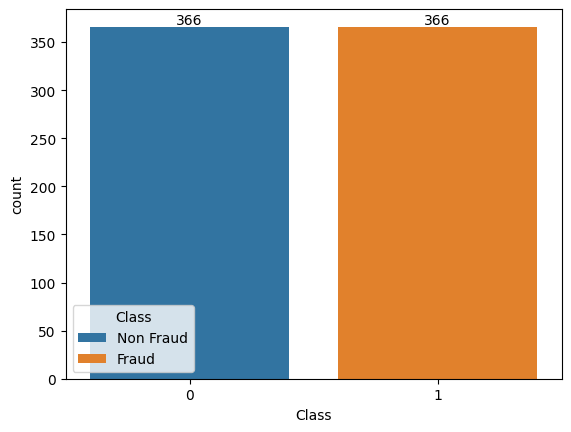

In [188]:
# Let's check our repartition on the first dataset of the list
ax =sns.barplot(data=undersampled_datasets[0]['Class'].value_counts().reset_index(), x='Class', y='count', hue= 'Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

new_labels = ['Non Fraud', 'Fraud']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=new_labels, title='Class')
plt.show()

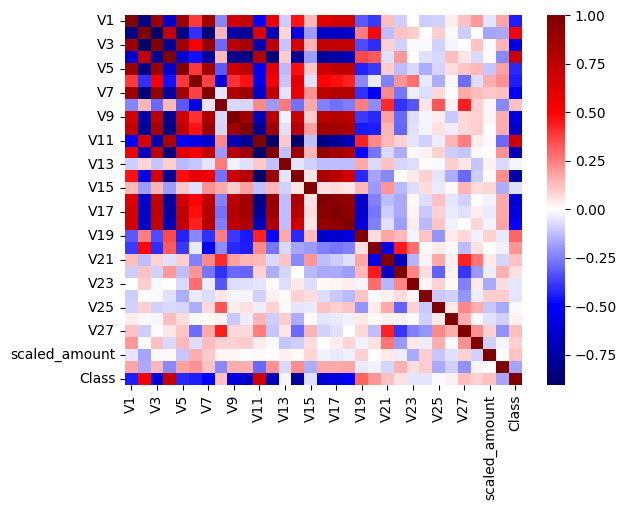

In [189]:
# Let's look at a heatmap!

sns.heatmap(data= undersampled_datasets[0].corr(), cmap = "seismic", center = 0)
plt.show()

Nice carpet. Now we'll take the line of the correlation matrix corresponding to the class

In [190]:
corr_matrix_0 = undersampled_datasets[0].corr()['Class']
display(corr_matrix_0.sort_values(ascending = False).drop('Class'))

V4               0.704892
V11              0.691119
V2               0.519762
V19              0.306297
V20              0.209731
V27              0.129930
scaled_amount    0.123656
V8               0.120973
V21              0.114008
V28              0.086615
V22              0.055258
V26              0.026694
V25             -0.008955
V13             -0.018985
V23             -0.050976
V24             -0.055100
V15             -0.061726
scaled_time     -0.172724
V5              -0.421604
V1              -0.440608
V6              -0.441338
V7              -0.498044
V18             -0.506076
V3              -0.573054
V9              -0.573372
V17             -0.589653
V16             -0.619685
V10             -0.645887
V12             -0.690789
V14             -0.746214
Name: Class, dtype: float64

It really look like the order of the ROC AUC Score, we're not out of the blue!

In [191]:
# Now we'll make the average correlation matrix

df_matrix= pd.DataFrame()
for mini_df in undersampled_datasets:
    matrix =  mini_df.corr()['Class'].drop('Class')
    df_matrix = pd.concat((df_matrix,matrix), axis = 1)

df_matrix_mean = df_matrix.T.mean()
display(df_matrix_mean.sort_values(ascending=False))

V4               0.707055
V11              0.687852
V2               0.517358
V19              0.295647
V20              0.190946
V8               0.128953
V27              0.115566
V21              0.108795
scaled_amount    0.092059
V22              0.069724
V28              0.059343
V26              0.032280
V25              0.005555
V13             -0.008879
V23             -0.049232
V15             -0.066712
V24             -0.074422
scaled_time     -0.160200
V5              -0.424770
V6              -0.430283
V1              -0.449526
V7              -0.500606
V18             -0.507031
V9              -0.556038
V3              -0.576200
V17             -0.586715
V16             -0.619020
V10             -0.645209
V12             -0.695085
V14             -0.746206
dtype: float64

Ok, Everything seems to be coherent here.

## Machine Learning

We'll use XGBoost as a model, and his argument scale_pose_weight to adapt to the imbalaced situation.
So i have to calculate it by making the division of the proportions:

In [192]:
count_neg = y_original_train.value_counts(1)[0]
count_pos = y_original_train.value_counts(1)[1]
spw =  count_neg/count_pos
print(spw)

541.6448087431694


Now for the choice of the parameters we'll try to use the optuna library!
So we'll work this way:
We'll make a cross validation with 5 splits on the train set.
 -Each split will be time series splits (to preserve the chronology) on our train set
 -We'll scale the split
 -We'll fit our model
 -We'll calculate the roc auc score
And we let optuna get the best params!

In [193]:
TSC_CV = TimeSeriesSplit(n_splits=5)
#Necessary Optuna Metric
auc_scorer = make_scorer(roc_auc_score, response_method='predict_proba')

In [194]:
def objective_with_pipeline(trial, X, y, cv_splitter, sp_weight, metric_scorer):
    """Fonction objectif Optuna avec Pipeline : maximise l'AUC-ROC via TimeSeriesSplit."""

    # 2. Hyperparameters search
    param = {
        # Tree construction
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        
        # Overfitting gestion
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 10.0),
        
        # Sous-échantillonnage (variance)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # Constantes
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': sp_weight # Of course
    }

    # 3. Model and pipeline
    xgb_model = XGBClassifier(
        **param,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Le Pipeline garantit que le RobustScaler est FIT sur chaque pli d'entraînement
    model_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('xgb', xgb_model)
    ])

    # 4. Évaluation par validation croisée temporelle
    # On passe X_original_train a la cross validation
    scores = cross_val_score(
        model_pipeline,  
        X,              
        y,              
        cv=cv_splitter,
        scoring=metric_scorer,
        n_jobs=-1
    )

    return scores.mean()


# 5. Lancement de l'étude Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(
#     lambda trial: objective_with_pipeline(trial, X_original_train, y_original_train, TSC_CV, spw, auc_scorer),
#     n_trials=100, # Nombre d'essais
#     show_progress_bar=True)


In [195]:
# # Récupération des meilleurs paramètres
# BEST_PARAMS = study.best_params
# print(f"AUC-ROC moyenne (Validation Croisée) : {study.best_value:.4f}")
# print(f"Meilleurs hyperparamètres trouvés : {BEST_PARAMS}")

In [196]:
# AUC-ROC moyenne (Validation Croisée) : 0.9797
BEST_PARAMS = {'n_estimators': 881, 'max_depth': 9, 'learning_rate': 0.0048887156152875935, 'gamma': 0.5069524604456046, 'min_child_weight': 4.063958385869923, 'subsample': 0.6342379067900331, 'colsample_bytree': 0.6209657210195962}

In [197]:
# 1. CRÉATION ET ENTRAÎNEMENT DU PIPELINE FINAL
# Le Pipeline est créé avec les BEST_PARAMS et le SCALE_POS_WEIGHT
final_xgb = XGBClassifier(
    **BEST_PARAMS,
    scale_pos_weight=spw,
    random_state=42,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss'
)

final_xgb.fit(X_original_train, y_original_train)
print("✅ Modèle final entraîné sur l'intégralité de X_original_train.")


# 2. ÉVALUATION FINALE SUR LE TEST SET CHRONOLOGIQUE
# Le Pipeline gère automatiquement le .transform() pour X_test
print("\n--- Évaluation des performances de généralisation ---")

# a. AUC-ROC (Area Under the Curve - meilleure métrique de séparation)
y_pred_proba = final_xgb.predict_proba(X_original_test)[:, 1]
final_auc_roc = roc_auc_score(y_original_test, y_pred_proba)

# b. Rappel (Recall) (Taux de fraudes correctement détectées au seuil 0.5)
y_pred_class = final_xgb.predict(X_original_test)
final_recall = recall_score(y_original_test, y_pred_class)


# 3. AFFICHAGE DES RÉSULTATS
print(f"AUC-ROC (Generalization sur X_test) : {final_auc_roc:.4f}")
print(f"Rappel (Recall à 0.5 sur X_test) : {final_recall:.4f}")


C:\Users\nicol\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle final entraîné sur l'intégralité de X_original_train.

--- Évaluation des performances de généralisation ---
AUC-ROC (Generalization sur X_test) : 0.9887
Rappel (Recall à 0.5 sur X_test) : 0.8000


--- RÉSULTATS D'OPTIMISATION DU SEUIL (Contrainte P >= 0.20) ---
Seuil de classification actionnable (T) : 0.065300
Précision cible atteinte : 0.2000
Rappel obtenu (Recall) : 0.8909
AUPRC globale du modèle : 0.8580


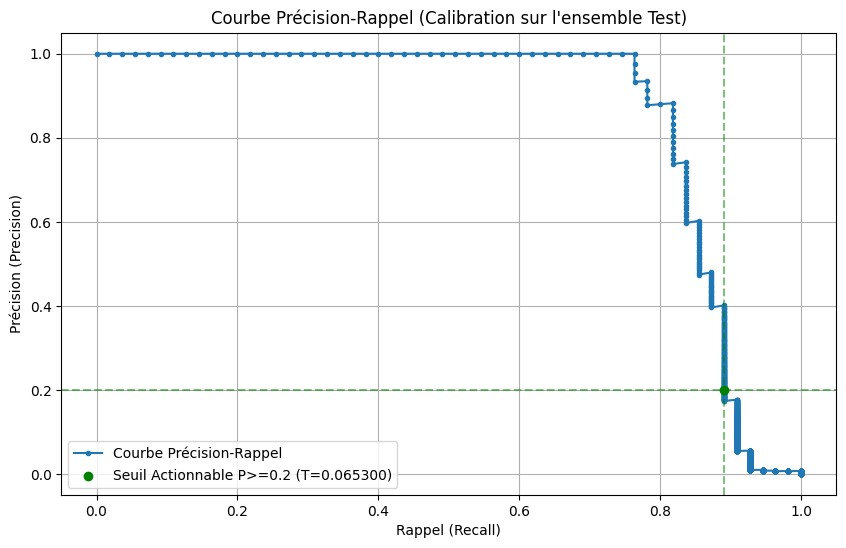

In [198]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CALCUL DE LA COURBE ---
# Calcule la précision, le rappel, et les seuils pour toutes les probabilités
precision, recall, thresholds = precision_recall_curve(y_original_test, y_pred_proba)

# --- 2. TROUVER LE SEUIL ACTIONNABLE (Contrainte métier : Precision >= 0.20) ---

# Trouver tous les indices où la précision est supérieure ou égale à 0.20
# On utilise precision[:-1] pour aligner la taille avec thresholds
valid_indices = np.where(precision[:-1] >= 0.20)[0]

# On choisit le SEUIL LE PLUS BAS qui satisfait P >= 0.20,
# car un seuil plus bas maximise le Recall.
# Dans les tableaux scikit-learn, cela correspond au dernier indice valide.
ix_actionnable = valid_indices[0]

best_threshold_actionnable = thresholds[ix_actionnable]

# --- 3. ÉVALUATION AU NOUVEAU SEUIL ACTIONNABLE (Sur l'ensemble Test) ---
# Appliquer le seuil actionnable
y_pred_new_threshold = (y_pred_proba >= best_threshold_actionnable).astype(int)

# Calculer les métriques avec ce nouveau seuil
recall_at_actionnable = recall_score(y_original_test, y_pred_new_threshold)
precision_at_actionnable = precision_score(y_original_test, y_pred_new_threshold)

# L'AUPRC est indépendante du seuil. Elle mesure la performance globale du modèle.
AUPRC_final = average_precision_score(y_original_test, y_pred_proba)

print(f"--- RÉSULTATS D'OPTIMISATION DU SEUIL (Contrainte P >= 0.20) ---")
print(f"Seuil de classification actionnable (T) : {best_threshold_actionnable:.6f}")
print(f"Précision cible atteinte : {precision_at_actionnable:.4f}")
print(f"Rappel obtenu (Recall) : {recall_at_actionnable:.4f}")
print(f"AUPRC globale du modèle : {AUPRC_final:.4f}")

# --- 4. VISUALISATION (CORRIGÉE) ---
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Courbe Précision-Rappel')

# Positionnement du point actionnable aux coordonnées de la Precision et du Recall obtenus
plt.scatter(x=recall_at_actionnable, y=precision_at_actionnable, marker='o', color='green', 
            label=f'Seuil Actionnable P>={0.20} (T={best_threshold_actionnable:.6f})', zorder=5)

# Lignes d'aide
plt.axvline(x=recall_at_actionnable, color='g', linestyle='--', alpha=0.5)
plt.axhline(y=precision_at_actionnable, color='g', linestyle='--', alpha=0.5)

plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision (Precision)')
plt.title('Courbe Précision-Rappel (Calibration sur l\'ensemble Test)')
plt.legend()
plt.grid(True)
plt.show()

In [200]:
# --- 1. Définition des Variables et Seuil ---

# Définition du seuil calibré sur l'ensemble TEST
# On utilise la valeur précise que vous avez trouvée :
T_actionnable = best_threshold_actionnable 

# Assurez-vous d'utiliser vos variables VAL adéquates (e.g., X_original_val, y_original_val)
X_data_val = X_original_val 
y_true_val = y_original_val 

# --- 2. Prédictions sur l'Ensemble VAL ---

# a. Calcul des probabilités de fraude sur VAL
y_proba_val = final_xgb.predict_proba(X_data_val)[:, 1]

# b. Prédiction de classe Optimisée (Application du seuil T)
# Si la probabilité est >= T_actionnable, alors c'est 1 (Fraude)
y_pred_val_optimized = (y_proba_val >= T_actionnable).astype(int)

# --- 3. Calcul des Métriques sur VAL ---

# a. Métriques Globales (indépendantes du seuil)
auc_roc_val = roc_auc_score(y_true_val, y_proba_val)
auprc_val = average_precision_score(y_true_val, y_proba_val)

# b. Métriques au Seuil Optimisé T
precision_val_T = precision_score(y_true_val, y_pred_val_optimized)
recall_val_T = recall_score(y_true_val, y_pred_val_optimized)


# --- 4. Affichage des Résultats ---
print("\n--- RÉSULTATS D'ÉVALUATION FINALE SUR VAL (Gold Standard) ---")
print(f"Taux de fraude dans VAL : {y_true_val.sum() / len(y_true_val) * 100:.4f}%")
print("-" * 50)
print(f"Métrique 🎯 Seuil Optimisé (T = {T_actionnable:.6f}) :")
print(f"  Precision (Actionnabilité) : {precision_val_T:.4f} (Cible : 0.20)")
print(f"  Rappel (Recall - Détection) : {recall_val_T:.4f} (Taux de détection réel)")
print("-" * 50)
print(f"Métrique 📈 Performance Globale (Indépendante du Seuil) :")
print(f"  AUC-ROC (Séparation des classes) : {auc_roc_val:.4f}")
print(f"  AUPRC (Capacité pour la classe rare) : {auprc_val:.4f}")


--- RÉSULTATS D'ÉVALUATION FINALE SUR VAL (Gold Standard) ---
Taux de fraude dans VAL : 0.1222%
--------------------------------------------------
Métrique 🎯 Seuil Optimisé (T = 0.065300) :
  Precision (Actionnabilité) : 0.1943 (Cible : 0.20)
  Rappel (Recall - Détection) : 0.7885 (Taux de détection réel)
--------------------------------------------------
Métrique 📈 Performance Globale (Indépendante du Seuil) :
  AUC-ROC (Séparation des classes) : 0.9763
  AUPRC (Capacité pour la classe rare) : 0.7623
